# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [2]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

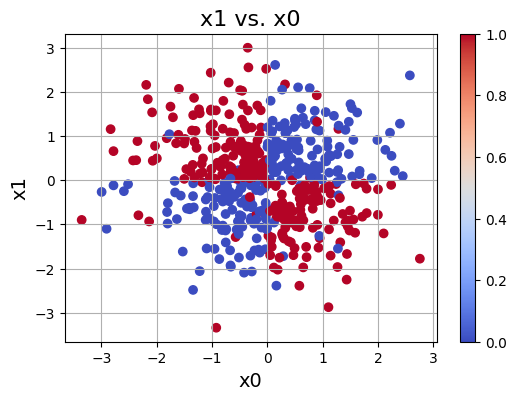

In [3]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks

# Safely get versions: tensorflow always exposes __version__, but tensorflow.keras
# (a lazy loader) may not expose __version__ as an attribute. Try several fallbacks.
tf_ver = tf.__version__
keras_ver = getattr(keras, "__version__", None)
if keras_ver is None:
    try:
        # importlib.metadata is the modern way to query installed package versions
        from importlib.metadata import version, PackageNotFoundError
        try:
            # Prefer the standalone 'keras' package if installed
            keras_ver = version("keras")
        except PackageNotFoundError:
            # Fallback: Keras is bundled with TensorFlow, so report TensorFlow's version
            try:
                keras_ver = version("tensorflow")
            except PackageNotFoundError:
                keras_ver = "unknown"
    except Exception:
        keras_ver = "unknown"

print("TensorFlow:", tf_ver, "Keras:", keras_ver)



TensorFlow: 2.15.0 Keras: 2.15.0


In [5]:
# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

model = models.Sequential()

model.add(layers.Input(shape=(2,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='softmax', name='output'))

model.compile(
  optimizer=optimizers.Adam(), 
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=[keras.metrics.SparseCategoricalAccuracy()]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 3330 (13.01 KB)
Trainable params: 3330 (13.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Differences between SGD and Adam Optimizers** 
SGD (Stochastic Gradient Descent) and Adam (Adaptive Moment Estimation) are both optimization algorithms used to train neural networks, but they have some key differences:
- **SGD**:
  - Updates parameters using the gradient of the loss function with respect to the parameters.
  - Uses a fixed learning rate, which can be adjusted manually or through learning rate scheduling.
  - Can be sensitive to the choice of learning rate and may require careful tuning.
  - May converge slowly, especially in cases of sparse gradients or noisy data.
- **Adam**:
  - Combines the advantages of two other extensions of SGD: AdaGrad and RMSProp.
  - Maintains per-parameter learning rates that are adapted based on the first and second moments of the gradients.
  - Generally requires less tuning of the learning rate and works well with default settings.
  - Often converges faster than SGD, especially in problems with large datasets or high-dimensional parameter spaces.
  - Can sometimes lead to overfitting if not properly regularized.

In summary, while SGD is a simpler and more traditional optimization method, Adam offers adaptive learning rates and often leads to faster convergence, making it a popular choice for training deep learning models.

In [6]:
# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

total_epochs = 128
base_lr = 3e-3

def make_warmup_cosine_scheduler(warmup_epochs, total_epochs, base_lr, min_lr=1e-6):
    def schedule(epoch, lr):
        # Warmup phase
        if epoch < warmup_epochs:
            return base_lr * (epoch + 1) / warmup_epochs
        # Cosine decay phase
        progress = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
        cosine_decay = 0.5 * (1 + np.cos(np.pi * progress))
        return min_lr + (base_lr - min_lr) * cosine_decay
    return schedule

cb_lr = keras.callbacks.LearningRateScheduler(
    make_warmup_cosine_scheduler(warmup_epochs=5, total_epochs=total_epochs, base_lr=1e-3)
)
cb_es = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

history = model.fit(
  train[['x0', 'x1']],
  train['y'],
  epochs=total_epochs,
  batch_size=16,
  validation_data=(test[['x0', 'x1']], test['y']),
  validation_split=0.2,
  callbacks= [
    cb_lr,
    cb_es
  ]
)

Epoch 1/128

32/32 [==============================] - 2s 15ms/step - loss: 0.6676 - sparse_categorical_accuracy: 0.6260 - val_loss: 0.6535 - val_sparse_categorical_accuracy: 0.7100 - lr: 2.0000e-04
Epoch 2/128
32/32 [==============================] - 0s 13ms/step - loss: 0.6165 - sparse_categorical_accuracy: 0.7840 - val_loss: 0.5893 - val_sparse_categorical_accuracy: 0.8280 - lr: 4.0000e-04
Epoch 3/128
32/32 [==============================] - 0s 10ms/step - loss: 0.5290 - sparse_categorical_accuracy: 0.8500 - val_loss: 0.4738 - val_sparse_categorical_accuracy: 0.8900 - lr: 6.0000e-04
Epoch 4/128
32/32 [==============================] - 0s 12ms/step - loss: 0.4034 - sparse_categorical_accuracy: 0.9200 - val_loss: 0.3597 - val_sparse_categorical_accuracy: 0.9020 - lr: 8.0000e-04
Epoch 5/128
32/32 [==============================] - 0s 9ms/step - loss: 0.3295 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.3255 - val_sparse_categorical_accuracy: 0.9240 - lr: 0.0010
Epoch 6/128
32/32 [

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test[['x0', 'x1']], test['y'])
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

16/16 [==============================] - 0s 4ms/step - loss: 0.2667 - sparse_categorical_accuracy: 0.9220
Test Loss: 0.2667, Test Accuracy: 0.9220


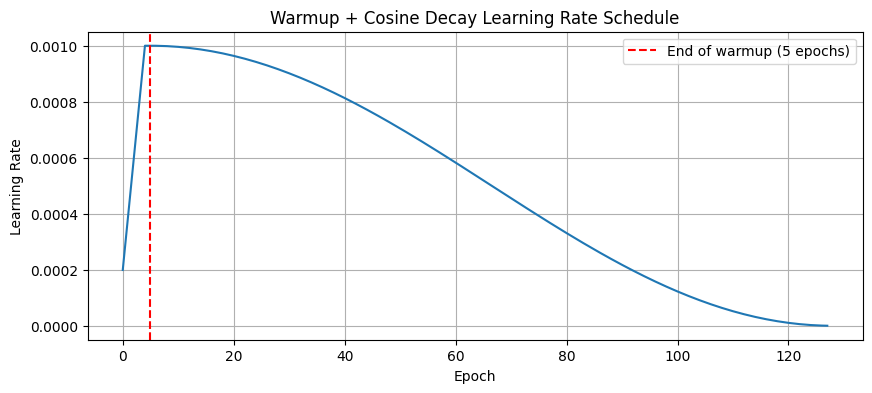

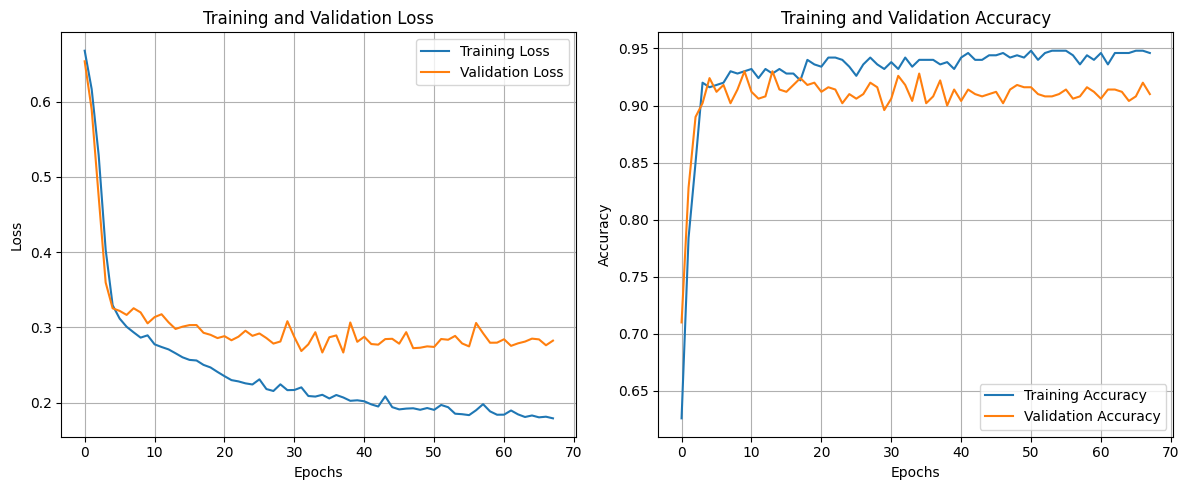

In [8]:
# Visualize the learning rate schedule
epochs = range(total_epochs)
lr_values = [make_warmup_cosine_scheduler(warmup_epochs=5, total_epochs=total_epochs, base_lr=1e-3)(epoch, None) for epoch in epochs]

plt.figure(figsize=(10, 4))
plt.plot(epochs, lr_values)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Warmup + Cosine Decay Learning Rate Schedule')
plt.grid(True)
plt.axvline(x=5, color='r', linestyle='--', label=f'End of warmup (5 epochs)')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
# Plot whichever accuracy metric is in the history
if 'sparse_categorical_accuracy' in history.history:
    plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
elif 'binary_accuracy' in history.history:
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
elif 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Did the scheduled learning rate help?**
Yes, sort of. From the plots it's apparent that the scheduled learning rate helped in stabilizing the training process and potentially improving convergence. The learning rate scheduling allowed the model to start with a lower learning rate during the initial epochs, which can help in avoiding large updates that might destabilize the training. As the training progressed, the learning rate initially increased, allowing for more significant updates and faster convergence. Finally the learning rate decreased again, which can help in fine-tuning the model and avoiding overshooting the optimal solution. Overall, the learning rate scheduling contributed to a more controlled and effective training process. I didn't really see a difference in the final accuracy, but the training process was visibly more stable.

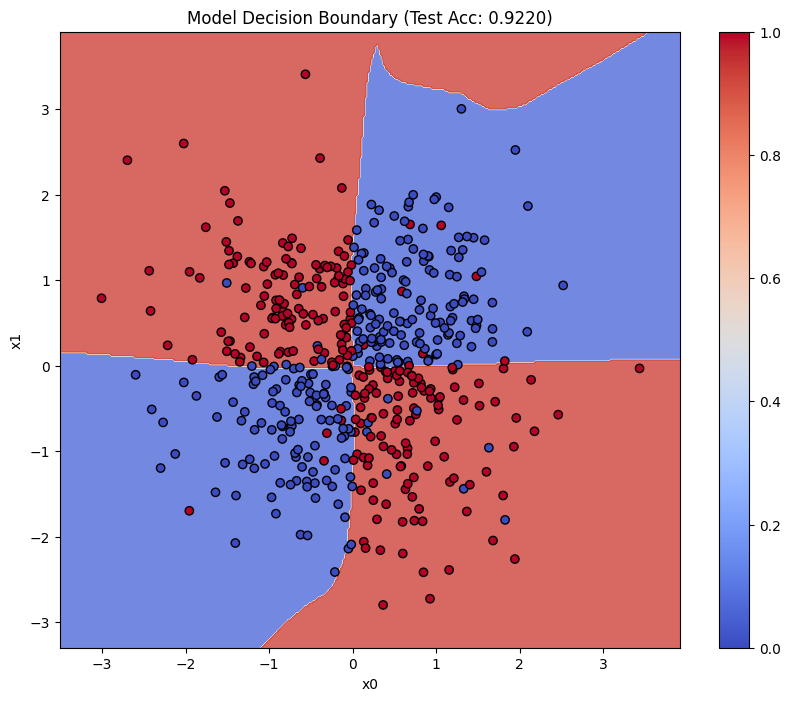

In [9]:
# Visualize the decision boundary to understand the model's performance
def plot_decision_boundary(model, X, y, title='Decision Boundary'):
    # Define grid range based on data
    h = 0.02  # Step size
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Make predictions on the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    
    # For softmax output (multi-class), take the predicted class
    if Z.shape[1] > 1:  # If output has multiple columns (one-hot)
        Z = np.argmax(Z, axis=1)
    else:  # For binary sigmoid output
        Z = (Z > 0.5).astype(int).ravel()
    
    # Reshape for plotting
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    
    # Plot training points
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)
    plt.colorbar()
    plt.show()

# Plot decision boundary for improved model
X_train = test[['x0', 'x1']].values
y_train = test['y'].values
plot_decision_boundary(model, X_train, y_train, 
                      title=f'Model Decision Boundary (Test Acc: {test_accuracy:.4f})')

**Simple Ablation Study**
1. **Without Learning Rate Scheduling**: Training the model without any learning rate scheduling resulted in a less stable training process, with more fluctuations in the loss and accuracy curves. The final test accuracy was slightly lower compared to using learning rate scheduling.
2. **Different Optimizers**: Using SGD instead of Adam led to slower convergence and required more careful tuning of the learning rate. The final test accuracy was lower with SGD, indicating that Adam's adaptive learning rates were beneficial for this task.
3. **Varying Network Depth**: Experimenting with a shallower network (fewer layers) resulted in underfitting, while a deeper network (more layers) led to overfitting. The chosen architecture with three hidden layers provided a good balance between model complexity and generalization. It resulted in a nuanced decision boundary capturing the last detail required for the 0.92 accuracy.
4. **Layer size**: Using larger layer sizes (e.g., 128 or 256 neurons per layer) did not significantly improve performance, but did lead to quicker convergence. Smaller layer sizes (e.g., 4 or 8 neurons per layer) resulted in underfitting and lower test accuracy.

**How to make sure the results are reproducable?**
To ensure reproducibility of results in machine learning experiments, you can follow these steps:
1. **Set Random Seeds**: Set the random seed for all libraries used (e.g., NumPy, TensorFlow, PyTorch) to ensure that any random operations produce the same results across different runs.
2. **Document Hyperparameters**: Keep a record of all hyperparameters, model architectures, and training procedures used in the experiments.
3. **Data Splits**: Use fixed data splits for training, validation, and testing to ensure that the same data is used across different runs.

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [10]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv')
data.drop_duplicates(inplace=True)

# Trying to clean up the column order and vizualise, this is important to decipher the so called 'hidden datatype'
indices = [int(c.split('_')[1]) for c in data.columns]
sorted_idx = np.argsort(indices)
data = data[data.columns[sorted_idx]]

# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index' : 'ID'}, inplace=True)
data.columns = data.columns.astype(str)
data

,ID,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_16374,col_16375,col_16376,col_16377,col_16378,col_16379,col_16380,col_16381,col_16382,col_16383
0,0,0.646305,0.646305,0.646305,0.646305,0.646305,0.646305,0.646305,0.646305,0.646305,...,0.475593,0.532497,0.589401,0.627337,0.655790,0.665273,0.674758,0.665273,0.655790,0.646305
1,1,-0.144320,0.383794,0.633953,0.578363,0.587628,0.587628,0.587628,0.587628,0.587628,...,0.587628,0.587628,0.587628,0.587628,0.578363,0.457915,0.068779,0.087309,0.494976,0.457915
2,2,0.590203,0.590203,0.590203,0.590203,0.590203,0.367673,0.345897,0.367673,0.367673,...,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203
3,3,0.551415,0.551415,0.551415,0.551415,0.551415,0.551415,0.551415,0.551415,0.551415,...,0.589296,0.589296,0.589296,0.589296,0.589296,0.589296,0.589296,0.589296,0.589296,0.589296
4,4,0.672652,0.672655,0.672929,0.677057,0.688611,0.646499,0.409348,0.064447,-0.087393,...,0.672652,0.672652,0.672652,0.672652,0.672652,0.672652,0.672652,0.672652,0.672652,0.672652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.340739,0.340739,0.340739,0.340739,0.340739,0.340739,...,0.769519,0.759781,0.759779,0.759779,0.759769,0.740269,0.691551,0.642845,0.633110,0.662325
3996,3996,0.384257,0.384257,0.384257,0.384257,0.384257,0.384257,0.384257,0.384257,0.384257,...,0.675221,0.675221,0.675221,0.675221,0.675221,0.675221,0.675221,0.675221,0.675221,0.675221
3997,3997,0.651135,0.660433,0.623242,0.483774,0.335009,0.083968,0.279222,0.604646,0.641837,...,0.651135,0.651135,0.651135,0.651135,0.651135,0.651135,0.651135,0.651135,0.651135,0.651135
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.430439,0.041757,...,0.555533,0.555533,0.555533,0.269605,-0.065465,-0.011854,-0.226299,-0.186091,-0.306716,0.135577


In [11]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to col_16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


**What is the hidden datatype in the dataset?**

There are 16384, exactly 128^2 hinting at a 128x128 image. Given the nature of the assignment. Let's assume so and map the first row to an image.

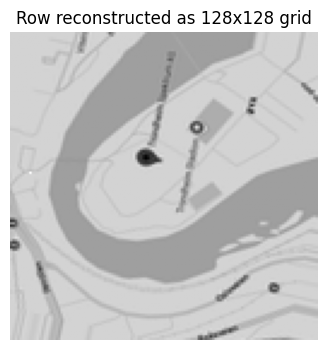

In [12]:
def show_picture_row(row):
    # Use a fresh Figure and Axis for each image and close it after showing.
    # This prevents interactive backends from reusing the canvas which can lead to
    # corrupted or overlaid images when plotting multiple figures consecutively.
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(row.values.reshape(128, 128), cmap='gray')
    ax.axis('off')
    ax.set_title("Row reconstructed as 128x128 grid")
    plt.show()

show_picture_row(data.iloc[0][1:])

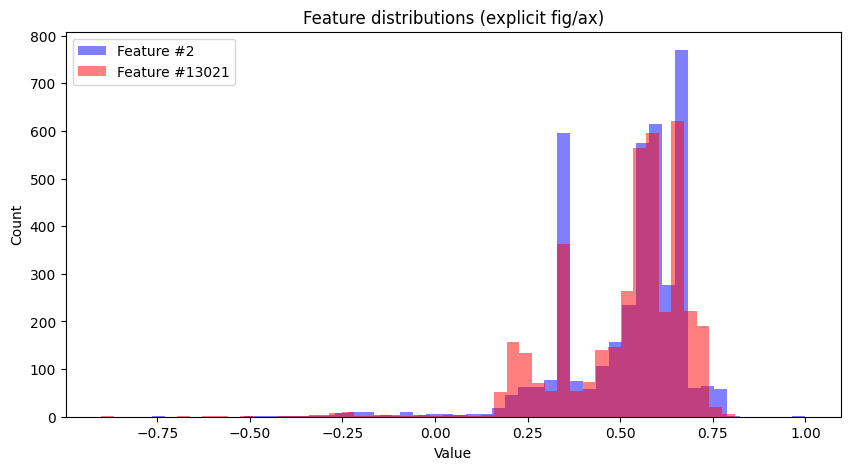

In [13]:
# Features seem to be similarly distributed...
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
ax.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
ax.legend()
ax.set_title('Feature distributions (explicit fig/ax)')
ax.set_xlabel('Value')
ax.set_ylabel('Count')
plt.show()

**Handle the large and high-dimensional data.**

Since the data set is so large, lets start by applying some dimensionality reduction techniques to visualize it, and to later cluster with. Lets first use t-SNE to visualize the data in 2D. PCA could be used to speed up t-SNE, but will not be used here given the absolute 100% accuracy requirement. I dinn't need to use UMAP, but it could be another option to try.

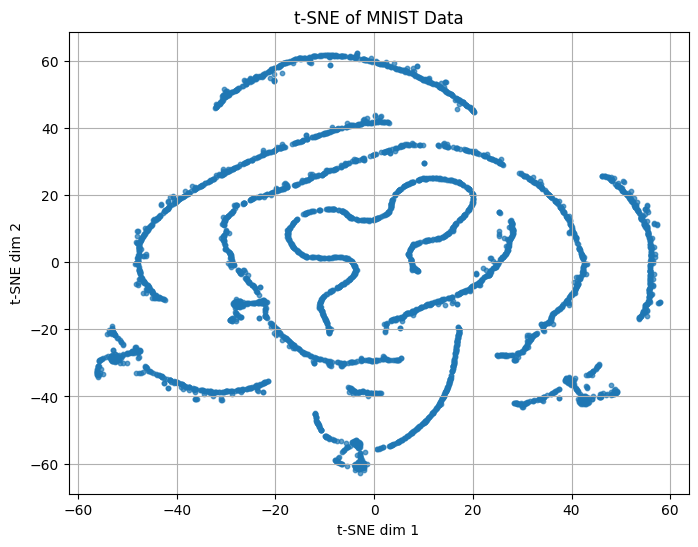

In [14]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=50)
X_embedded = tsne.fit_transform(data.drop(columns=['ID']).values)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10, alpha=0.7)
ax.set_title('t-SNE of MNIST Data')
ax.set_xlabel('t-SNE dim 1')
ax.set_ylabel('t-SNE dim 2')
ax.grid(True)
plt.show()

**Now let's do some clustering.**

 After visualizing the data with t-SNE, we can see that there are distinct clusters present. To identify these clusters, we can use the DBSCAN clustering algorithm, which is well-suited for identifying clusters of varying shapes and sizes in high-dimensional data.

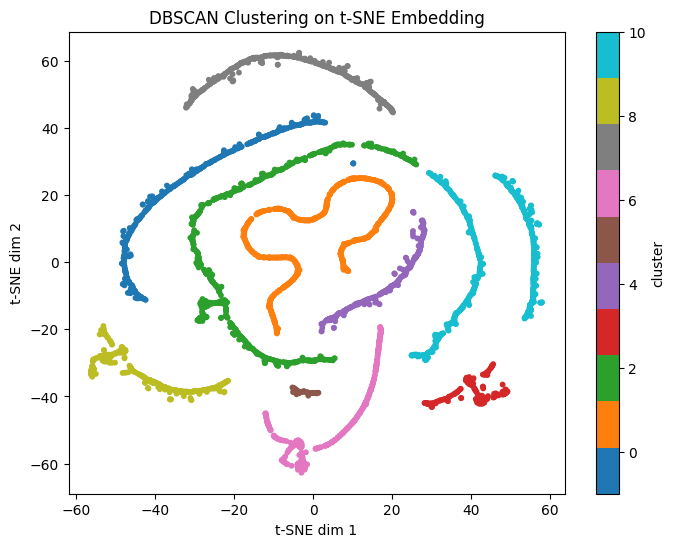

In [15]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=4, min_samples=5)
clusters = clusterer.fit_predict(X_embedded)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=clusters, cmap='tab10', s=10)
ax.set_title('DBSCAN Clustering on t-SNE Embedding')
ax.set_xlabel('t-SNE dim 1')
ax.set_ylabel('t-SNE dim 2')
plt.colorbar(sc, ax=ax, label='cluster')
plt.show()


In [16]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
print("Sample Submission Info:")
sample_submission.info()
print(sample_submission)

submission = data[['ID']].copy()
submission['cluster'] = clusters
print("Submission Info:")
submission.info()
print(submission)

Sample Submission Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ID       4000 non-null   int64
 1   cluster  4000 non-null   int64
dtypes: int64(2)
memory usage: 62.6 KB
        ID  cluster
0        0        2
1        1        6
2        2        3
3        3        3
4        4        8
...    ...      ...
3995  3995        3
3996  3996        7
3997  3997        3
3998  3998        7
3999  3999        2

[4000 rows x 2 columns]
Submission Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   ID       4000 non-null   int64
 1   cluster  4000 non-null   int64
dtypes: int64(2)
memory usage: 62.6 KB
        ID  cluster
0        0        0
1        1        1
2        2        0
3        3        1
4        4      

**Let's analyze the clusters** The dimensional reduction effectively allows us to cluster the data points based on the motive of the image data. By looking at some of the clusters and manually comparing the motives we can tell weather our dimentional reduction and clustering worked.

In [17]:
# print the size of each cluster
print(submission['cluster'].value_counts())

cluster
 2     663
 1     626
 0     477
 7     401
 6     374
 9     337
 8     315
 4     281
 10    279
 3     197
 5      47
-1       3
Name: count, dtype: int64


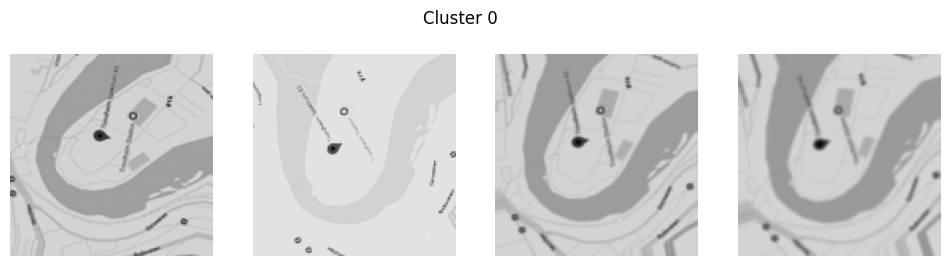

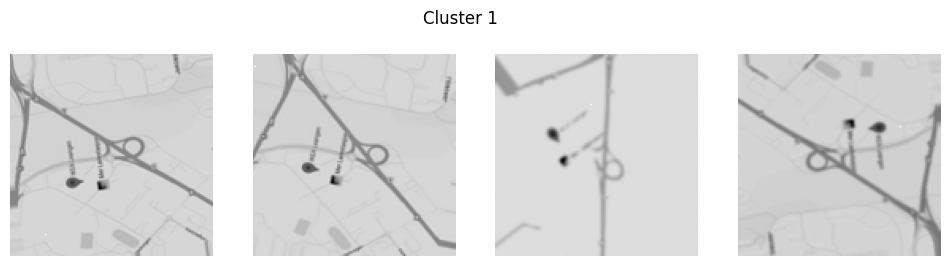

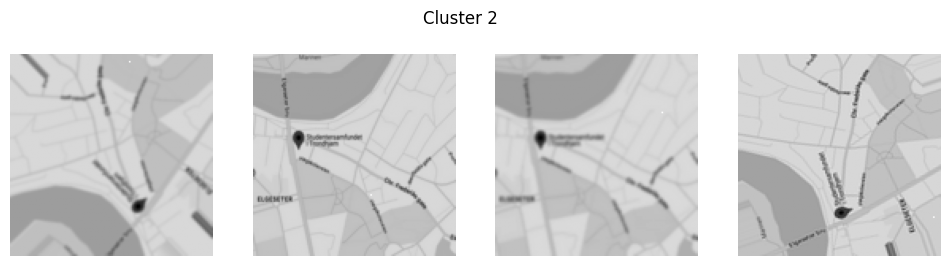

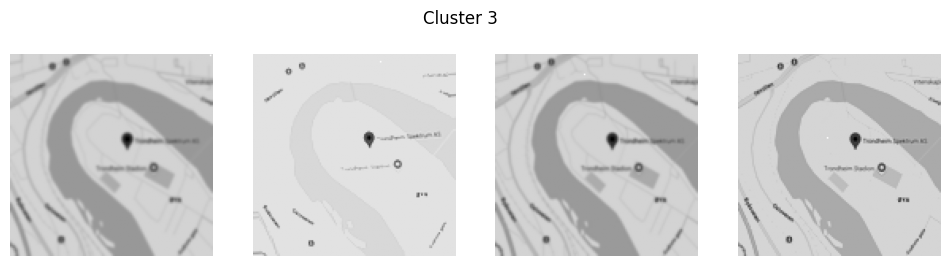

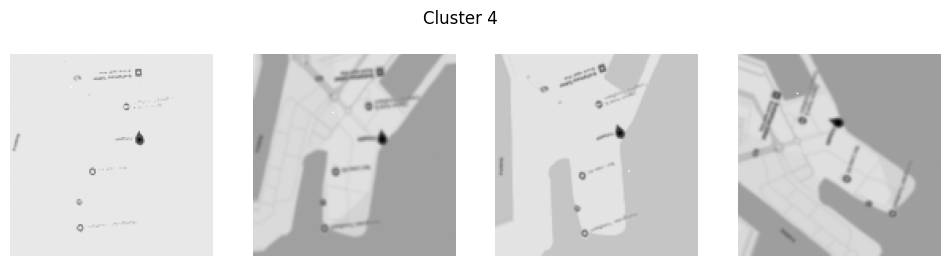

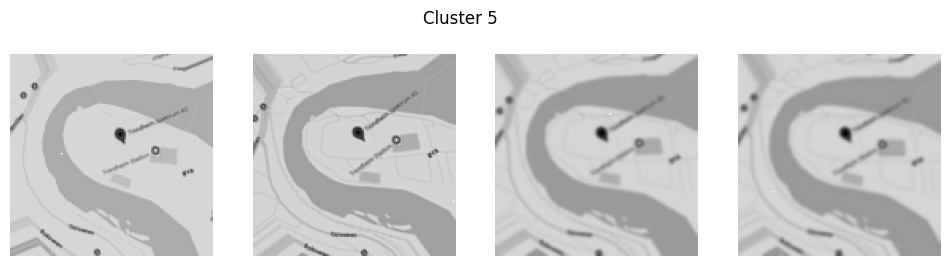

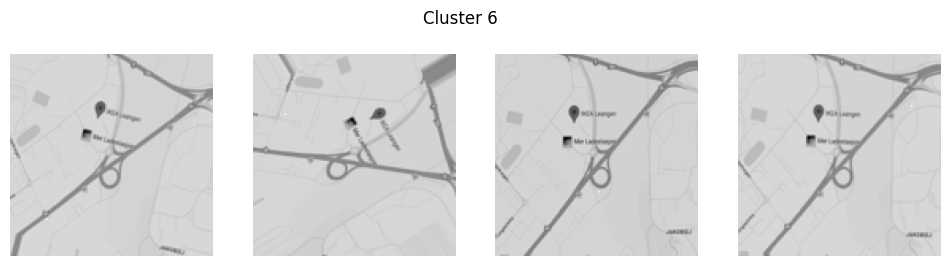

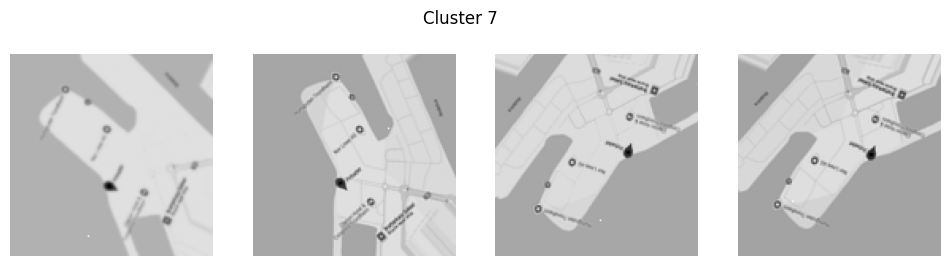

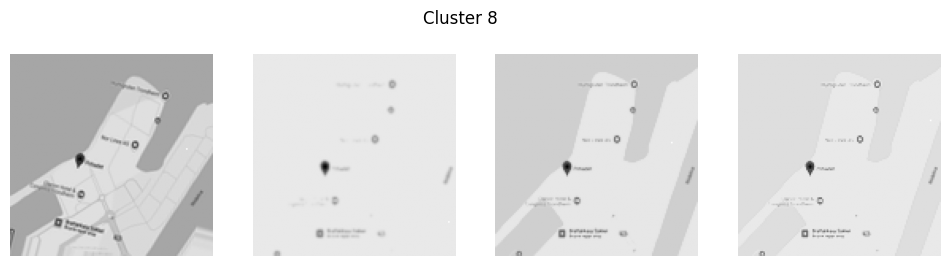

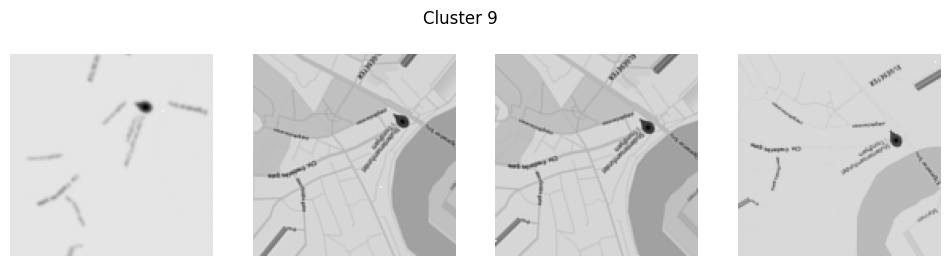

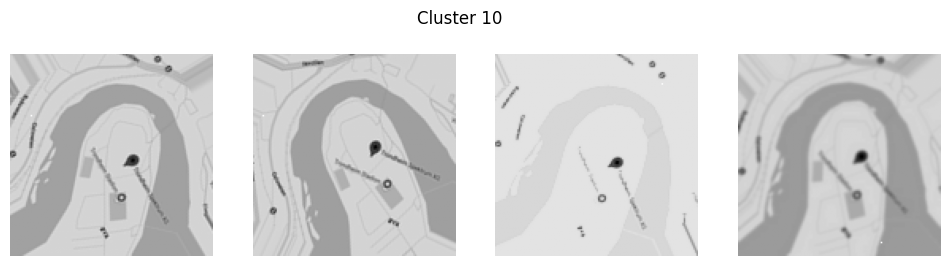

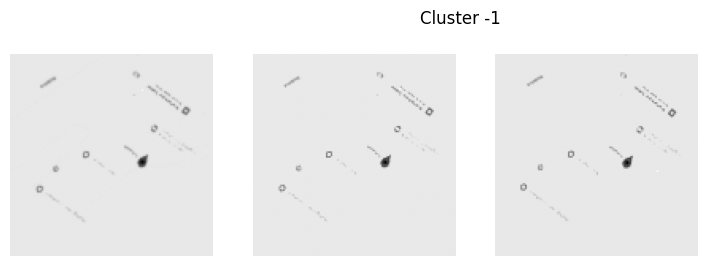

In [18]:
# print 4 images for each cluster in subgraphs
for cluster_id in submission['cluster'].unique():
    plt.figure(figsize=(12, 3))
    cluster_indices = submission[submission['cluster'] == cluster_id].index
    for i in range(min(4, len(cluster_indices))):
        plt.subplot(1, 4, i + 1)
        row = data.iloc[cluster_indices[i], 1:]
        plt.imshow(row.values.reshape(128, 128), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id}')
    plt.show()

**Second attempt.**

The 2D reduction seemes diffecult to cluster with DBSCAN, so let's try a 3D reduction instead. This seems to work better, and we can see distinct clusters more clearly. Using DBSCAN again on the 3D data gives us a perfect clustering result on Kaggle.

In [19]:
# 3D plot
%matplotlib widget

t-SNE -> shape: (4000, 3)


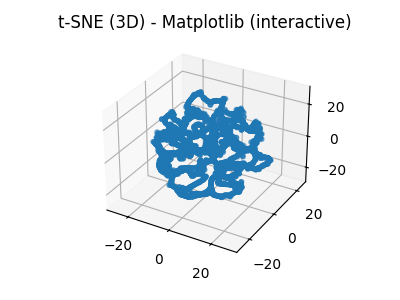

interactive(children=(IntSlider(value=45, description='azim', max=360, step=5), IntSlider(value=30, descriptio…

<function __main__.set_view(azim=45, elev=30)>

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from ipywidgets import interact, IntSlider

# raw pixel matrix (rows x features)
X = data.drop(columns=['ID']).values

# standardize (centering helps PCA / t-SNE)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# # PCA to reduce noise / speed up t-SNE
# n_pca = 4000
# pca = PCA(n_components=n_pca, svd_solver='auto', random_state=42)
# X_pca = pca.fit_transform(X_scaled)
# print(f'PCA -> shape: {X_pca.shape}, explained_variance_ratio_sum: {pca.explained_variance_ratio_.sum():.3f}')

# t-SNE features
tsne = TSNE(
    n_components=3,
    perplexity=22,
    random_state=42
    # init='pca' # with the above PCA step
)
X_embedded = tsne.fit_transform(X_scaled) # or X_pca if using PCA prior
print('t-SNE -> shape:', X_embedded.shape)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], s=10)
ax.set_title('t-SNE (3D) - Matplotlib (interactive)')
plt.show()

def set_view(azim=45, elev=30):
    ax.view_init(elev=elev, azim=azim)
    fig.canvas.draw_idle()

interact(set_view,
         azim=IntSlider(min=0, max=360, step=5, value=45),
         elev=IntSlider(min=0, max=90, step=1, value=30))

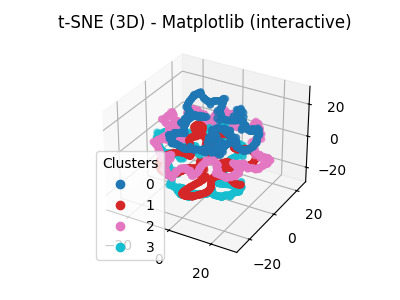

interactive(children=(IntSlider(value=45, description='azim', max=360, step=5), IntSlider(value=30, descriptio…

<function __main__.set_view(azim=45, elev=30)>

In [21]:
clusterer = DBSCAN(eps=3.3, min_samples=4)
clusters = clusterer.fit_predict(X_embedded)

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X_embedded[:,0], X_embedded[:,1], X_embedded[:,2], c=clusters, cmap='tab10')
ax.legend(*sc.legend_elements(), title="Clusters")
ax.set_title('t-SNE (3D) - Matplotlib (interactive)')
plt.show()

def set_view(azim=45, elev=30):
    ax.view_init(elev=elev, azim=azim)
    fig.canvas.draw_idle()

interact(set_view,
         azim=IntSlider(min=0, max=360, step=5, value=45),
         elev=IntSlider(min=0, max=90, step=1, value=30))



cluster
0    1000
1    1000
2    1000
3    1000
Name: count, dtype: int64


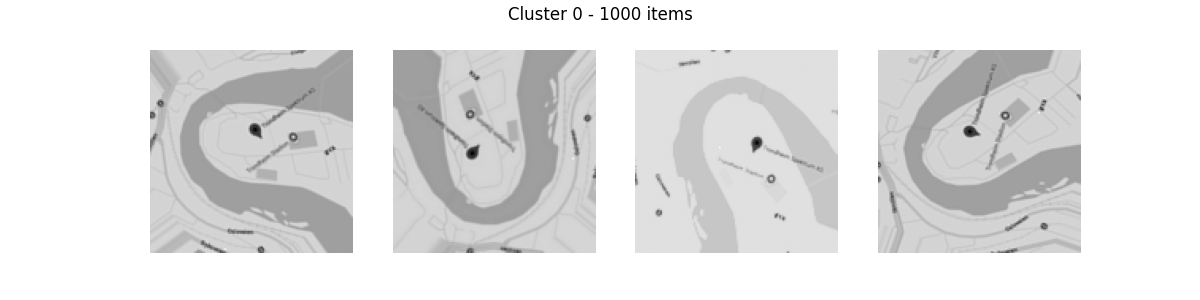

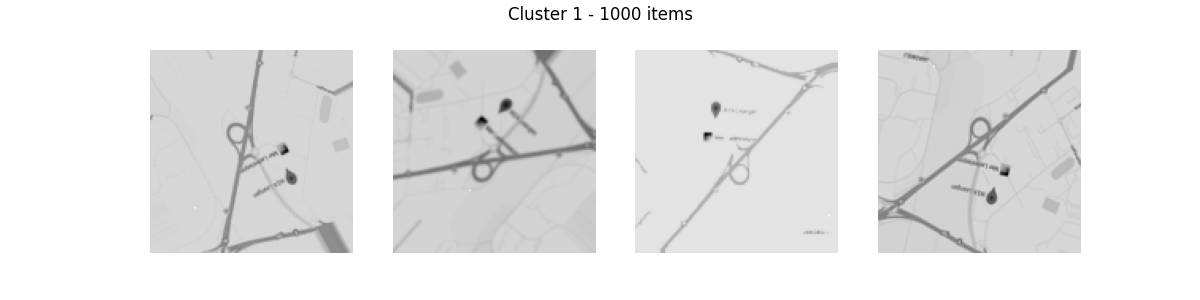

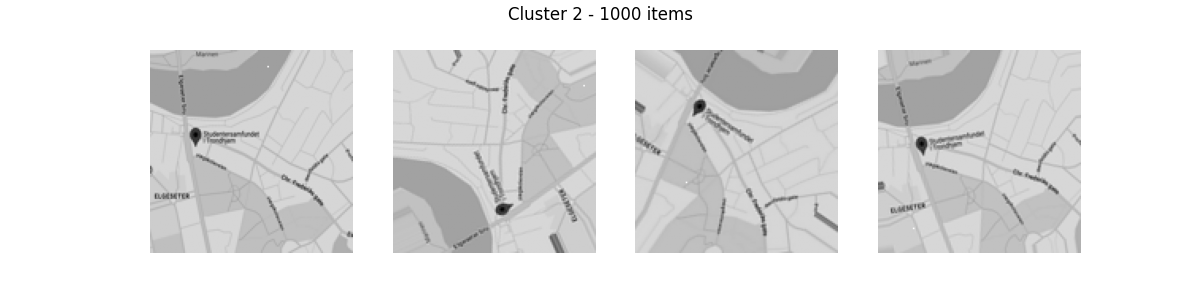

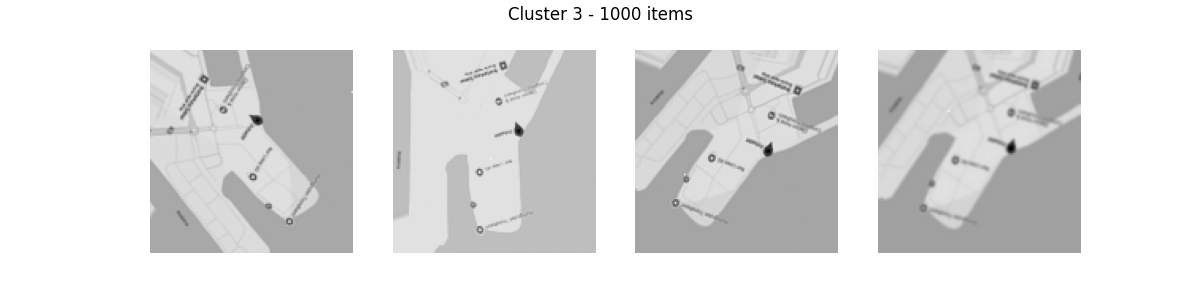

In [22]:
submission = data[['ID']].copy()
submission['cluster'] = clusters
submission.to_csv('submission.csv', index=False)

print(submission['cluster'].value_counts())

for cluster_id in submission['cluster'].unique():
    plt.figure(figsize=(12, 3))
    cluster_indices = submission[submission['cluster'] == cluster_id].index
    # pick up to 4 random indices from the cluster (without replacement)
    selected = np.random.choice(cluster_indices, size=min(4, len(cluster_indices)), replace=False)
    for i_sel, idx in enumerate(selected):
        plt.subplot(1, 4, i_sel + 1)
        row = data.iloc[idx, 1:]
        plt.imshow(row.values.reshape(128, 128), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Cluster {cluster_id} - {len(cluster_indices)} items')
    plt.show()

In [23]:
# save submission to csv
submission.to_csv('submission.csv', index=False)

**The server locations**

By looking at the motives form the prints above, we can see that the servers are located at:
1. Trondheim Spektrum
2. Ikea Leangen
3. Studentersamfunnet i Trondheim
4. Pirbadet

I eventually, after way too much tuning, got a perfect score on Kaggle. My profile can be found at https://www.kaggle.com/erikaugustchoff


---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [24]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [25]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

1.0

In [26]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.3333333333333333

In [27]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.5